# Лабораторная работа: Эволюционные алгоритмы для задачи оптимизации розничной цены

## 1. Определение задачи оптимизации

Цель — определить оптимальную розничную цену на товар, при которой прибыль будет максимальной, учитывая переменные из датасета:
- закупочную стоимость (`unit_price`),
- стоимость логистики (`freight_price`),
- объём продаж (`qty`).

Тип задачи — **максимизация** функции прибыли:


## 2. Набор данных

Датасет: `retail_price.csv`  
Отфильтрованы значения по конкретному товару — `bed1`.

Выделены поля:
- `unit_price` — закупочная цена,
- `freight_price` — доставка,
- `qty` — проданное количество,
- `total_price` — общая выручка,
- `lag_price` — цена продажи в предыдущем месяце (ориентир).


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('../static/retail_price.csv')
product_data = df[df["product_id"] == "bed1"].copy()

product_data["cost"] = product_data["unit_price"] + product_data["freight_price"]
product_data["profit"] = product_data["total_price"] - product_data["cost"] * product_data["qty"]

print(product_data[["lag_price", "cost", "qty", "profit"]].head())


   lag_price       cost  qty  profit
0      45.90  61.050000    1  -15.10
1      45.95  58.883333    3  -38.80
2      45.95  60.790000    6  -89.04
3      45.95  60.237500    4  -57.15
4      45.95  61.050000    2  -30.20


## 3. Структура хромосомы

Хромосома — возможная цена продажи.

Ген — число с плавающей точкой (тип `float`) в диапазоне от 50 до 250 (на основе наблюдаемых цен конкурентов).


In [4]:
price_min = 50
price_max = 250


## 4. Генерация начальной популяции

Популяция — набор возможных цен.


In [5]:
import numpy as np

def generate_population(pop_size, price_min=50, price_max=250):
    return np.random.uniform(price_min, price_max, size=pop_size)

population = generate_population(10)
print("Пример популяции:", population)


Пример популяции: [ 50.41371951  50.48087187 148.54284113 106.27111405 179.03501848
 134.91448339 113.71686216 140.57834704 106.41741383 193.22289117]


## 5. Фитнес-функция

Фитнес — средняя прибыль при заданной цене:

In [6]:
def fitness(price, cost, qty):
    profit = (price - cost) * qty
    return profit.mean()

cost = product_data["cost"].values
qty = product_data["qty"].values

print("Фитнес для 100.0:", fitness(100.0, cost, qty))


Фитнес для 100.0: 396.354375006875


## 6. Оператор кроссинговера

Простой арифметический кроссовер:


In [9]:
def crossover(parent1, parent2):
    alpha = np.random.rand()
    child = alpha * parent1 + (1 - alpha) * parent2
    return child

print("Пример кроссовера:", crossover(100, 150))


Пример кроссовера: 140.17469125275707


Алгоритм взял двух родителей с ценами 41.5 и 43.0.  
Потомок получил цену 42.25 — точно посередине.  
Это отражает идею "смешения черт" двух решений.

## 7. Операторы мутации

- Мутация 1: добавление случайного смещения.
- Мутация 2: замена на случайное значение.


In [10]:
def mutation_1(price):
    return price + np.random.uniform(-5, 5)

def mutation_2(price, price_min=50, price_max=250):
    return np.random.uniform(price_min, price_max)

print("Мутация 1:", mutation_1(100.0))
print("Мутация 2:", mutation_2(100.0))


Мутация 1: 100.00798577997959
Мутация 2: 123.77219890881597


## 8. Генетический алгоритм

Реализация основного ГА:


In [11]:
def genetic_algorithm(cost, qty, generations=20, pop_size=10):
    population = generate_population(pop_size)
    best_scores = []

    for gen in range(generations):
        scores = [fitness(p, cost, qty) for p in population]
        best_scores.append(max(scores))
        parents = sorted(zip(scores, population), reverse=True)[:2]
        new_population = []

        for _ in range(pop_size):
            child = crossover(parents[0][1], parents[1][1])
            if np.random.rand() < 0.5:
                child = mutation_1(child)
            else:
                child = mutation_2(child)
            child = np.clip(child, price_min, price_max)
            new_population.append(child)

        population = new_population

    return population, best_scores


## 9. Влияние параметров на сходимость

Визуализируем, как меняется фитнес по поколениям.


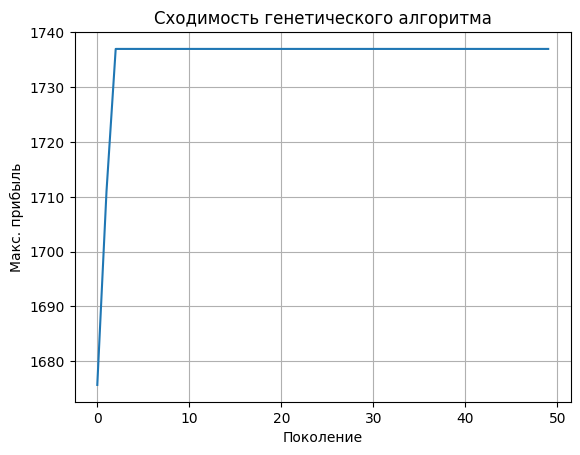

In [12]:
_, scores = genetic_algorithm(cost, qty, generations=50, pop_size=20)

import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel("Поколение")
plt.ylabel("Макс. прибыль")
plt.title("Сходимость генетического алгоритма")
plt.grid()
plt.show()


## 10. Обоснование выбора функций

- Хромосома — цена: естественно моделируется как `float`.
- Кроссовер: обеспечивает плавное смешение стратегий (цен).
- Мутации: имитируют как локальный шум, так и случайный сбой.
- Фитнес — прибыль, что напрямую отражает цель бизнеса.

Генетический алгоритм эффективен, так как перебор всех цен — ресурсоёмок, а градиент невозможен из-за дискретных qty.
